# Disclamer : 
This notebook is designed for younger audience, who are new to field of Data Science. The language used may not be suitable a industry implementation, although the approach would be fairly similar. I have tried to eleborate as much as I could, this has indeed resulted in a longer notebook. I could create a snappier version of the notebook for quick and easy consumption by the audience if required. 

The Notebook focuses the explaination and implementation. It avoids regularization, Hyperparameter tuning and training different models, keeping the content easily understandable by target audience.

Bag of words seem like a appropriate approach for the the target audience, but I have taken the liberty of explaining TFIDF vectorization in the easiest way possible. I can present another notebook implementing simpler bag of words, if required.

# Summary :  Gender Classification From Movie Dialogues
### Wouldn't it be awesome if we could build a AI so smart that it could identify the gender of a person by analyzing his/her sentenses? Well you are in for a treat, coz that's exactly what we are about to do in the following notebook! 
###It may seem a impossible task at first, but just bare with me, I am going to walk you through each step with detailed explaination through  the journey. 🛫


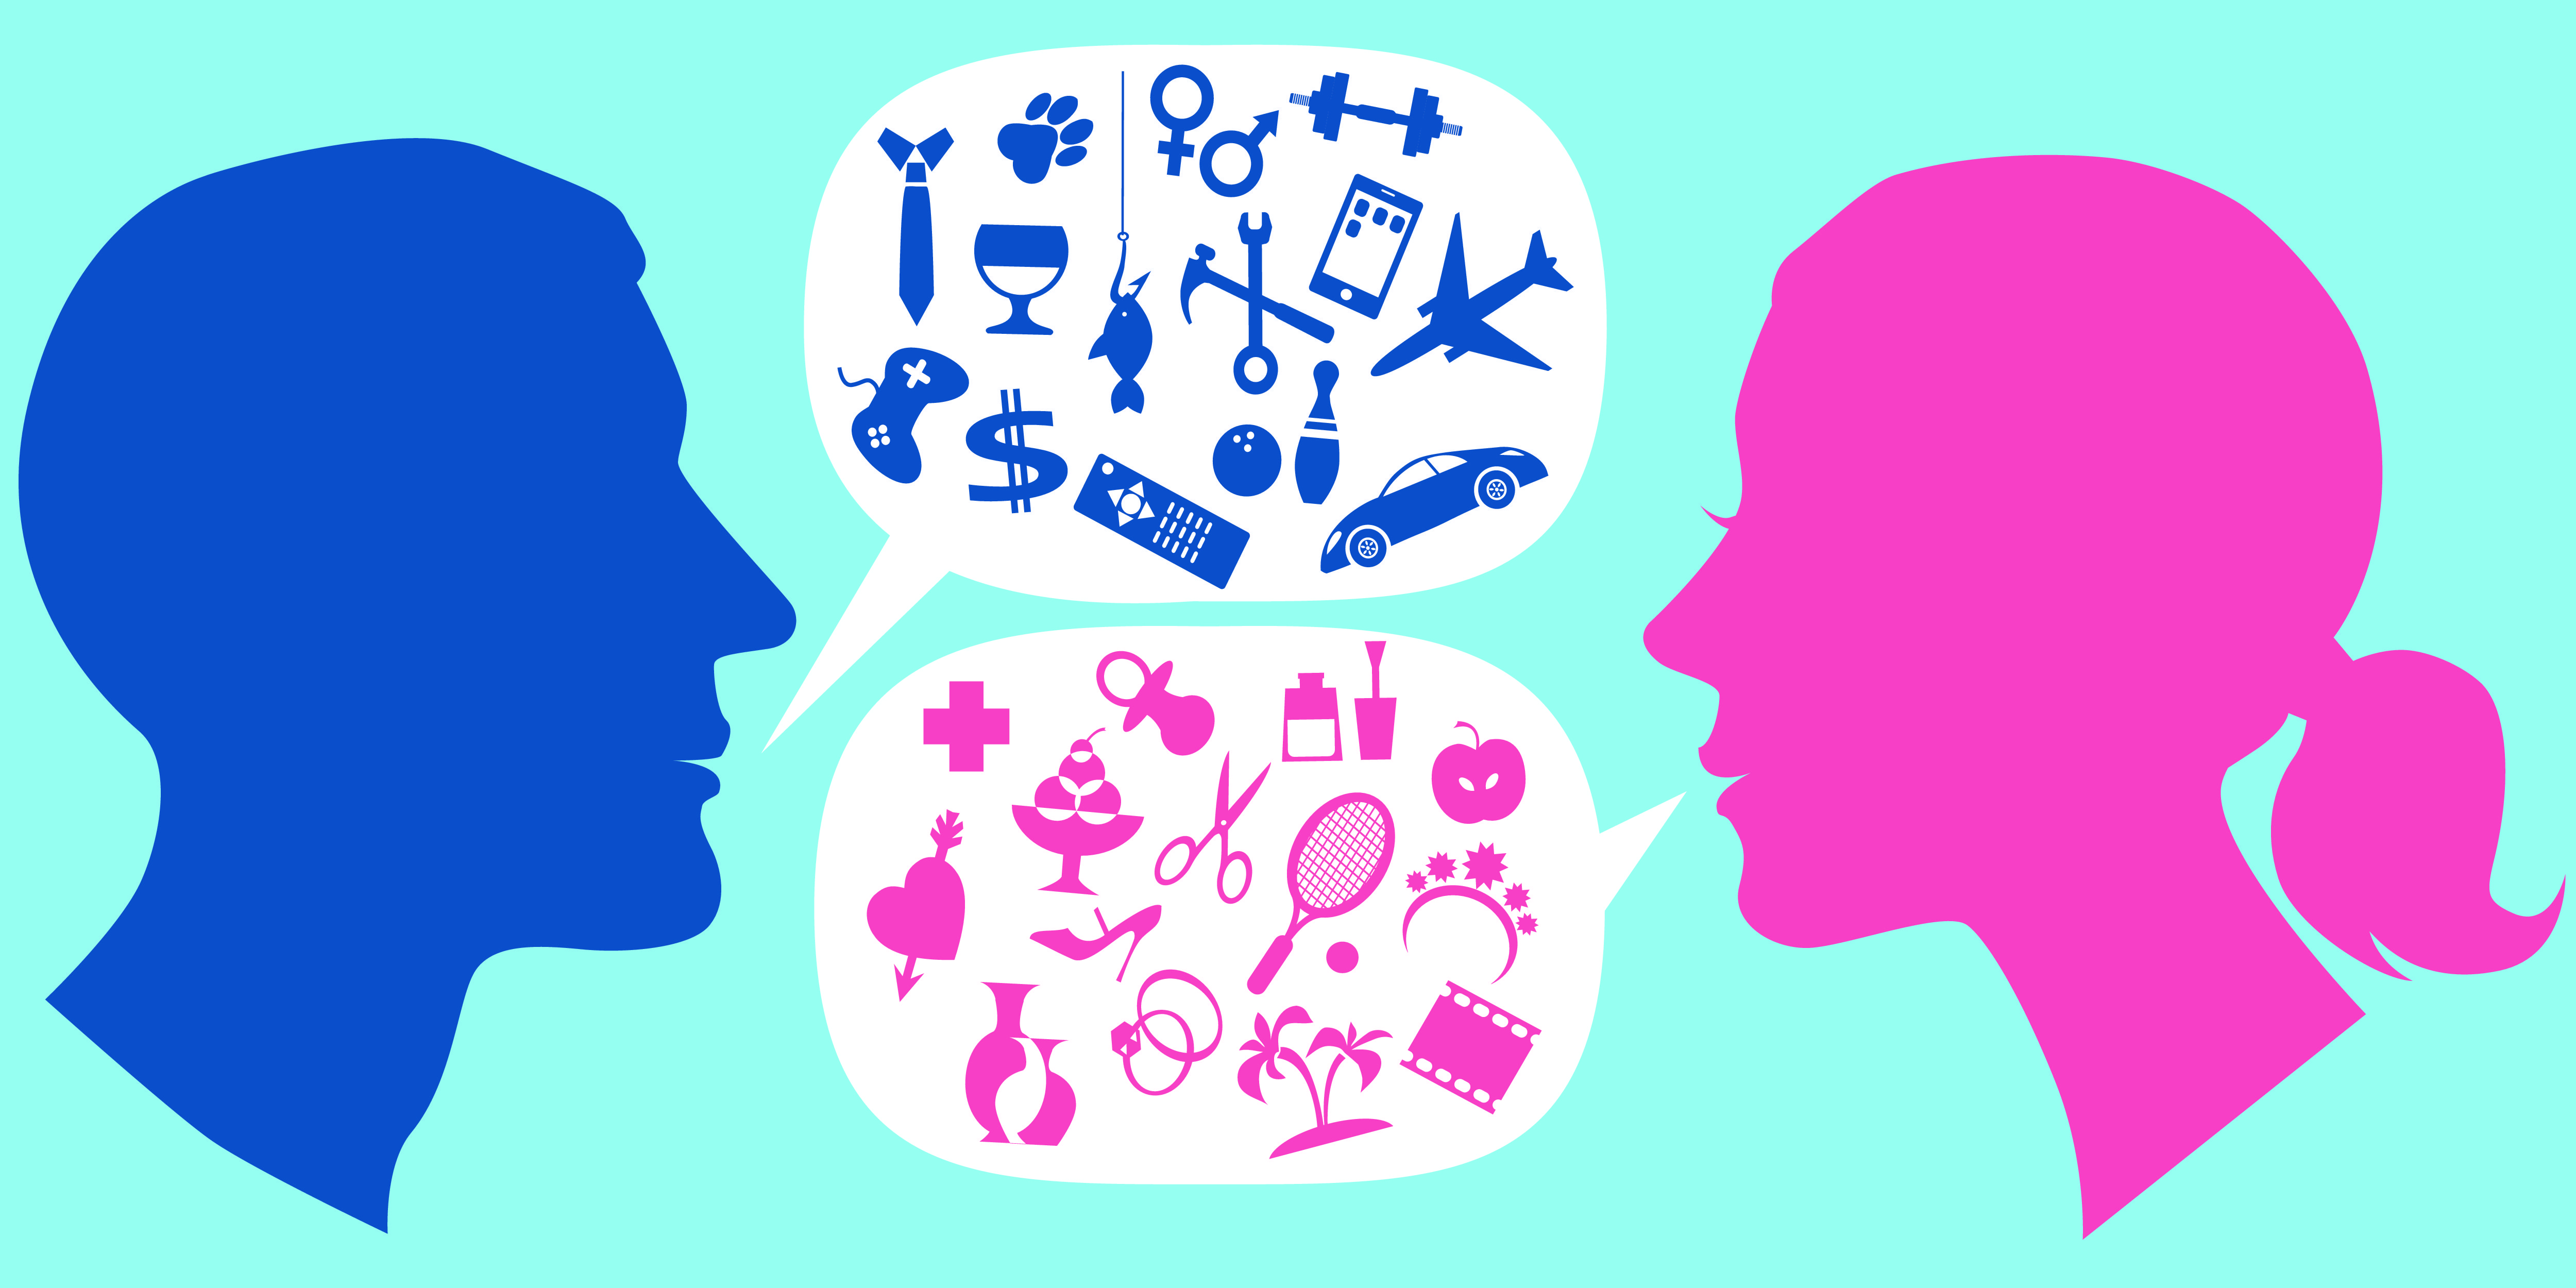

# About The Dataset
We all love movies, don't we? Well the [Dataset](https://www.kaggle.com/Cornell-University/movie-dialog-corpus) we are going to use consists of fictional conversations extracted from raw movie scripts.
The Dataset consists of:


*   220,579 conversational exchanges between 10,292 pairs of movie character
*   Involves 9,035 characters from 617 movies
*   Total 304,713 utterances

In this supervised learning task, we are going to use doalogues from movie scripts mapped to the gender of the speaker.
Unfortunately this mapping is not readily available in the dataset, Bummer? 🤦

Not to  worry, we can just create the mapping with few lines of codes. Being able to map data across different datasets is a important skill for machine learning. 👌

The link contains five datasets of which we require only two,
1.  "movie_characters_metadata.tsv" : Containing character genders
2.  "movie_lines.tsv" : Containing actual movie lines

Lets load in the dataset and take a look at some entries

# Imports 
Lets load in some libraries that we are going to use.



In [220]:
import numpy as np                              # for some data sctuctures(array) and mathematical functions.
import pandas as pd                             # for some advanced data structures for data manipulation and analysis.
import matplotlib.pyplot as plt                 # for drawing some cool graphs and pictures
import seaborn as sns                           # to make our pictures even cooler 😎
import nltk                                     # natural language toolkit for processing English language
import re                                       # Regular expression

from sklearn.model_selection import train_test_split            # Splitting for training and testing
from sklearn.feature_extraction.text import TfidfVectorizer     # Transforms text to feature vectors that can be used as input to estimator
from sklearn.metrics import accuracy_score,confusion_matrix     # Metrics to evaluate our model

### Loading the Movie Characters Dataset 🦧
I have saved all files in my GDrive for easy access.

In [221]:
# Lets load characters dataset into a dataframe(a tabular structure similar to exel), uising pandas "read_csv()" function as shown in line 5
# We will used "error_bad_lines=False" to drop any bad lines with lot of seperators.
# The tab seperated dataset has no column names so lets pass 'header=None' argument.
characters = pd.read_csv('/content/drive/MyDrive/Datasets/Movie Dialog Corpus Gender Classification/movie_characters_metadata.tsv', 
                            sep='\t', error_bad_lines=False, header=None,  warn_bad_lines=False)
# Lets look at first 5 records of the characters dataset using "Dataframe.head()" function as shown in line no 8
characters.head()

,0,1,2,3,4,5
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6


### Loading the Movie Lines Dataset 🎥

In [222]:
# we will use similar loading techniques we used for characters dataset i.e skipping bad lines and default header.
# Loading the dataset uisng pandas.read_csv() function as shown in line 3 below
lines = pd.read_csv('/content/drive/MyDrive/Datasets/Movie Dialog Corpus Gender Classification/movie_lines.tsv', 
                    sep='\t', error_bad_lines=False, header=None,  warn_bad_lines=False)
# Lets look at first 5 records of lines dataset using "Dataframe.head()" function as shown in line no 6
lines.head()

,0,1,2,3,4
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


# Data Cleaning

Great, we can see the entries in our datasets. Our datasets will have to undergo some cleaning before we can put it to use. 🙈

I know, I know, I am not a big fan of the word "cleaning" either. But trust me its one of the most important skills in data sciences. Infact 80% of the time taken to build a data science project is taken up by cleaning. Let me show you how cleaning can be fun as well, and the reward is totally worth the efforts. 


Lets start with our characters dataset.

In [223]:
# Our dataset column names dont make a lot of sense, lets replace column names with the help of dataset description on kaggel
# The DataFrame.columns lets us set custom column names as shown in line 3 below
characters.columns = ['Character_ID', 'Character_Name', 'Movie_ID', 'Movie_Title', 'Gender', 'Position_In_Credits']
# Lets see if the column names make any sense now using the '.head()' in line no 5 below
characters.head()

,Character_ID,Character_Name,Movie_ID,Movie_Title,Gender,Position_In_Credits
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6


Wonderful! Looks like our column names now represent the data accurately.  

This dataset contains a lot of information, some of its columns are not needed for our use case. Lets filter out information we dont need.

In [224]:
# We can pass in a list of columns we want to keep to a Dataframe to select only those columns and assign it to 'characters_filtered' as shown in line 2 bolow.
characters_filtered = characters[['Character_ID', 'Gender']]
# Lets look at the filtered dataset using the '.head()' function as shown in line 4 below
characters_filtered.head()

,Character_ID,Gender
0,u0,f
1,u1,?
2,u2,m
3,u3,?
4,u4,m


Alright, Lets try to understand the columns after filtering.

Character_ID : Unique ID given to each character(Performer). The entries in the column are alphanumeric

Gender : Gender of the Performer

## Performing similar cleaning task on the 'lines' dataset. 

In [225]:
# The following code in line no 2 assigns custom names to the columns just like how we did for characters dataset
lines.columns = ['line_ID', 'Character_ID', 'Movie_ID', 'Character_Name', 'Dialogue']
# The following code lets us have a look at the first few lines with the '.head()' function
lines.head()

,line_ID,Character_ID,Movie_ID,Character_Name,Dialogue
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


In [226]:
# Lets filter the 'lines' dataset keeping only the columns we need i.e "Character_ID" and "Dialogue" and assign it to a new variable with the code below
lines_filtered = lines[['Character_ID', 'Dialogue']]
# The following code lets us have a look at the first few lines of 'lines_filtered' with the '.head()' function
lines_filtered.head()

,Character_ID,Dialogue
0,u0,They do not!
1,u2,They do to!
2,u0,I hope so.
3,u2,She okay?
4,u0,Let's go.


Lets try to understand the columns after filtering.

Character_ID : Unique ID given to each character(Performer). The entries in the column are alphanumeric.

Dialogue : Dialogue(lines) by the Performer.

# Data Analysis
In this section we will find some statestics that can help us discover useful information about our data.
Lets start with the characters dataset 


In [227]:
# The below line of code shows us the unique entries in the "Gender" column and the values on the right shows the number of its occurances
characters_filtered['Gender'].value_counts()
# For example the value "M" appeared 145 time in our "Gender" column of the characters dataset

?    6008
m    1899
f     921
M     145
F      44
Name: Gender, dtype: int64

The "Gender" column has 5 unique values, Here is what those values represent 
1. "?" : unknown/missing 
2. "m" : Male 
3. "f" : Female
4. "M" : Male
5. "F" : Female


In [228]:
# The missing entries provides no information, lets remove all the missing entries. 
# we do this by checking the "Gender" column, where the value is not equal to "?" using "!=" comparison, so that we are left with values other than "?"
# This will give us a boolean array like follows which can be used as a filter.
filter = characters_filtered['Gender'] != '?'
# Next we apply this boolean filter on the characters dataset, keeping only the records where boolean value is true
# This returns a filtered version of the dataset where entries are anything other than "?"
characters_cleaned = characters_filtered[filter]

In [229]:
# Lets check if there are any "Null" values using DataFrame.notna() function and create another filter 
# Following line creates a filter which returns a boolean array, assiging True where "Gender" column is not "Null".
filter_null = characters_cleaned['Gender'].notna()
# Next we apply the Filter to our Dataset keeping only non Null values
characters_cleaned = characters_cleaned[filter_null]

# We have two seperate values("m" and "M") representing male and ("f" and "F") representing female
# Lets unify this so there is only one value representing a Male and one representing female
# The following code replaces "m" to "M", in line 7 and "f" to "F" in line 8 using 'Dataframe.replace()' function applied on the "Gender" column
# The inplace attribute makes sure that the changes are made on the Dataframe itself and not on a copy
characters_cleaned['Gender'].replace('m', "M", inplace=True)
characters_cleaned['Gender'].replace('f', "F", inplace=True)

In [230]:
# Now that we have the dataset cleaned lets take a look at how many male to female performers we have using the DataFrame.value_counts() function
characters_cleaned['Gender'].value_counts()

M    2044
F     965
Name: Gender, dtype: int64

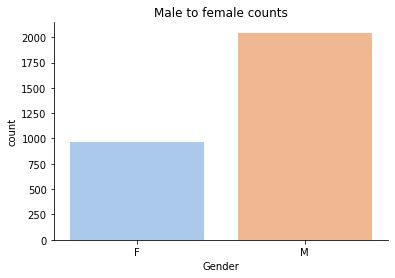

In [231]:
# The following code plots the number of male to female characters using the seaborn.countplot() function, where we passin the "Gender" column of the dataframe
sns.countplot(x=characters_cleaned['Gender'], palette='pastel');
# Adding a title to the graph with plt.title() function
plt.title("Male to female counts")
# Removing unwanted boundary lines from the graph with seaborn.despine() function
sns.despine()

Our graph shows twice the male population as compared to female which checks out, as there are 965 Females and 2044 Females

In [232]:
# In the following code we use "DataFrame.info()" function showing us number of columns, column labels, column data types, memory usage, range index.
characters_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3009 entries, 0 to 9021
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Character_ID  3009 non-null   object
 1   Gender        3009 non-null   object
dtypes: object(2)
memory usage: 150.5+ KB


So we have about 3009 unique performers(Male and Female) in the dataset! thats a lot of celebrities. 

Lets see what stats we can discover in the Lines Dataframe

In [233]:
# The following code shows the total number of unique dialogues using the DataFrame.nunique() function 
lines_filtered['Dialogue'].nunique()

251306

Wow! There are 251306 unique dialogues form our performers.

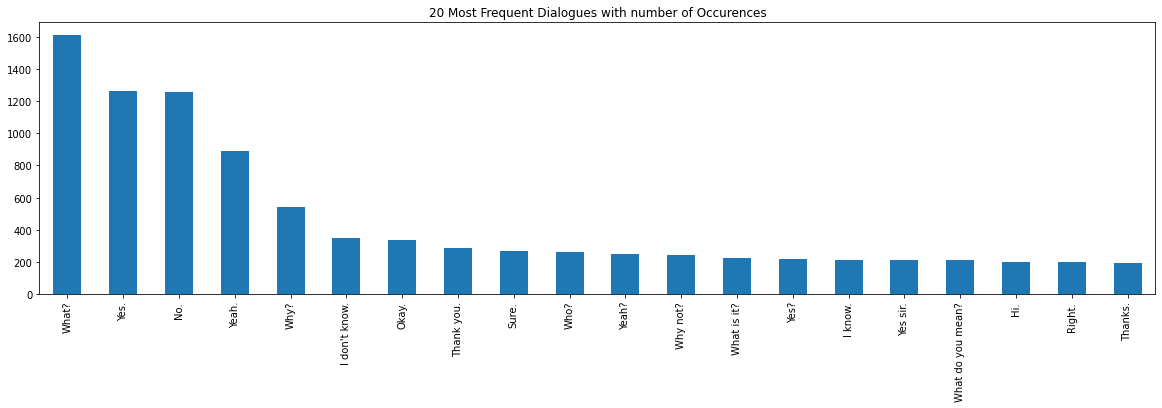

In [234]:
plt.figure(figsize=(20,5))
# Lets find the 5 most frequent dialogues using the DataFrame.value_counts() followed by .head() function
Frequent_Dialogues = lines_filtered['Dialogue'].value_counts()
# 5 most frequent dialogues can be obtained by selecting first 5 entries using the [:5] selection
top20 = Frequent_Dialogues[:20]
# The following code plots a barplot of 20 most frequent dialogues with Series.plot.bar() function
top5.plot.bar();
# Following code adds a title to the barplot
plt.title("20 Most Frequent Dialogues with number of Occurences");

"What?" seems to be a popular dialogue for its been used maximum(1610) times!

# Plotting Wordcloud
Wouldnt it be cool to see a collage of dialogues? wordcloud is a fun way of representing sketching such collage. Let me show you how easy it is to draw one.

In [235]:
# we create a dataframe form the most frequent dialogues we found earlier using pd.DataFrame() and using only top 50 results
# the reset_index() function creates another index for us so that dialogues can have its own seperate column
text = pd.DataFrame(Frequent_Dialogues[:50]).reset_index()
# Next we join the results using the .join function
text = ' '.join(text['index'])

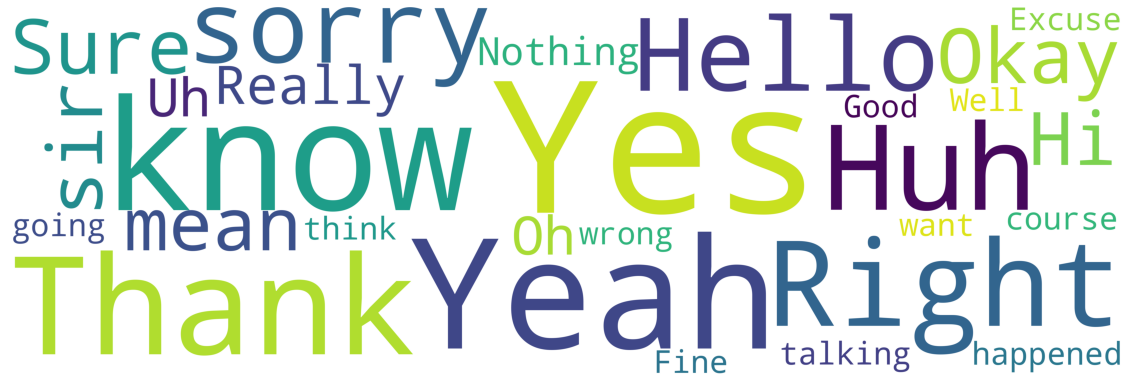

In [262]:
# Following line of code imports wordcloud library
from wordcloud import WordCloud
# Following code sets the figure size using plt.figure(figsize=()) function
plt.figure(figsize = (20,10))
# We initialize the wordcloud by and set up our parameters such as width, height and background color
word_cloud = WordCloud(collocations = False, background_color = 'white', width = 6000, height =2000).generate(text)
# Following code shows the code using plt.imshow() function
plt.imshow(word_cloud)
# We can trun off the default axis will code below
plt.axis("off");

Lets take a look at some more informative statistics.

In [237]:
# In the following code we look for any "Null" values in our dataframe using the DataFrame.isna() function which returns a boolean array, returning True wherever value is "null"
# We apply Dataframe.sum() which adds all true occurences in the boolean array
lines_filtered.isna().sum()

Character_ID    4285
Dialogue        4539
dtype: int64



4285 entries in "Character_ID" column are Null

4539 erntries in "Dualogue" column are Null


In [238]:
# Next we drop records containing null values using DataFrame.dropna() function
lines_filtered.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [239]:
# Lets use DataFrame.info() function to find number of columns, column labels, column data types, memory usage, range index, and the number of cells in each column (non-null values)
lines_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288663 entries, 0 to 293201
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Character_ID  288663 non-null  object
 1   Dialogue      288663 non-null  object
dtypes: object(2)
memory usage: 6.6+ MB


# Merging Datasets
Awesome, we now have two Dataframes each containing two columns.
1.  characters_cleaned : "Character_ID" & "Gender"
2.  lines_filtered : "Character_ID" & "Dialogue"

We will merge the dataset on the "Character_ID" column since it is common to both DataFrames hence can act as pivot column.

In [240]:
# The following code merges the two dataframes on "Character_ID" column using the pd.merge() function.
# The "how" argument makes sure we keep records with "Character_ID" that are present in both the dataframes by passing in "inner" attribute, this is also called inner join.
df = pd.merge(characters_cleaned, lines_filtered, on="Character_ID", how='inner')
# lets look at first few entries in our merged dataframe using dataframe.head() function
df.head()

,Character_ID,Gender,Dialogue
0,u0,F,They do not!
1,u0,F,I hope so.
2,u0,F,Let's go.
3,u0,F,Okay -- you're gonna need to learn how to lie.
4,u0,F,Like my fear of wearing pastels?


# Understanding the problem Statement
Looking at the dataframe above, our task is to predict the value in the "Gender" column if the value in the "Dialogue" column is known.

# Feature Engineering
In this section we try to create more features using existing information from our dataset. These additional features can provide interesting statistics and can provide additional information during the training process. We create two new features as follows :

In [241]:
# Create a new feature that shows number of characters in a dialogue with DataFrame.str.len() Function
df['Characters'] = df['Dialogue'].str.len()
# For Example the dialogue "I hope so." has 10 characters including spaces and symbols like period "."

# Create another feature that represents number of words in the dialogue using the DataFrame.str.count() and passing in (" ") space as a argument
# This will return number of times space appears in the sentence, to which we add 1, giving us number of words in that sentense.
df['Words'] = df['Dialogue'].str.count(' ') + 1

# Lets take a look at first few instances in our Featured Engineered Dataset using DataFrame.head() function.
df.head()

,Character_ID,Gender,Dialogue,Characters,Words
0,u0,F,They do not!,12,3
1,u0,F,I hope so.,10,3
2,u0,F,Let's go.,9,2
3,u0,F,Okay -- you're gonna need to learn how to lie.,46,10
4,u0,F,Like my fear of wearing pastels?,32,6


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


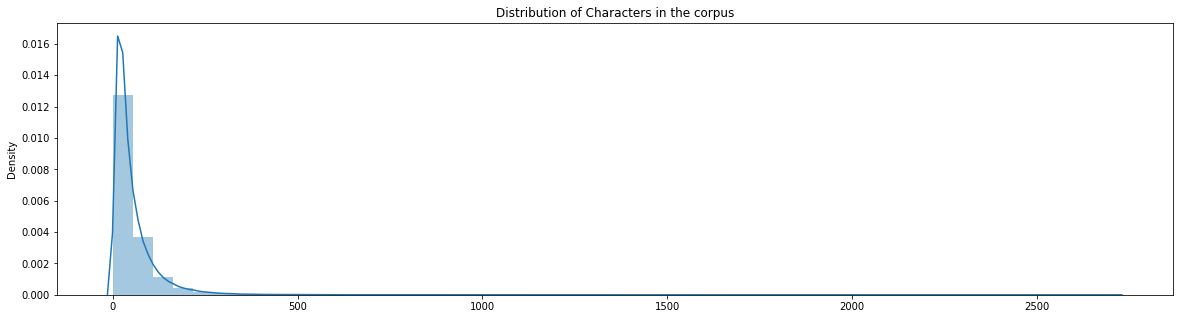

In [242]:
# Lets plot the distribution of the new feature "Characters" 
# The following code sets the figure size using plt.figure(figsize=()) function
plt.figure(figsize=(20,5))
# The following code plots a distribution plot using Seaborn.distplot() function
sns.distplot(x=df['Characters'])
# Following code sets the title for the graph with plt.title()
plt.title("Distribution of Characters in the corpus");

As we can see most dilogues have very gew words, almost always below 50

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Words in the corpus')

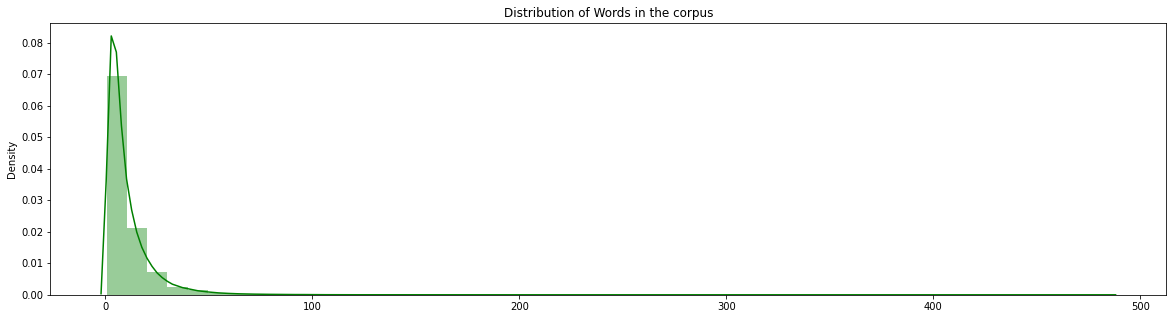

In [243]:
# The following code sets the figure size using plt.figure(figsize=()) function
plt.figure(figsize=(20,5))
# The following code plots a distribution plot using Seaborn.distplot() function
sns.distplot(x=df['Words'], color='green')
# Following code sets the title for the graph with plt.title()
plt.title("Distribution of Words in the corpus")

As we can see most Dialogues have less than 20 words.

# Dialogue Cleaning
Before we start training our model we will have to perform a series of preprocessing on our "Dialogues" column so that our model can gain maximum information.

This is the last cleaning sequence you will find in the notebook, I promise ✋


1. Our dialogues data is bit messy, lets take care of any non letters by removing them from the dialogues.
2. Convert all letters to lower case
3. We will split the sentence on " "(space) extracting words from sentence
4. Removing stopwords
5. Lemmatization

Lets see how the process works on a dummy sentence before we apply to dialogue corpus.


In [244]:
# Lets set up a dummy string with some numbers and symbols.
string = "I have 6 guns, @Joker!"

In [245]:
# The following code removes any non alphabetic character from the string using a regular expression
# The pattern we are looking for is given by "[^a-zA-Z]" which matches all characters small[a-z] and capital[A-Z]
# We use the re.sub() to replace substrings in strings with " "(space).
letters = re.sub("[^a-zA-Z]", " ", string)
letters

'I have   guns   Joker '

In [246]:
# Next we convert all the letters to lower case with string.lower() 
# combined with string.split() function extracting words from sentence 
words = letters.lower().split()
words

['i', 'have', 'guns', 'joker']

Removing Stopwords : Stopwords often dont supply any additional meaning, e.g. : is,am,are,the. Its better to take them away.

In [247]:
# The following code loads stopwords from nltk.nltk.corpus.stopwords.words() and we pass in "English" for our use case.
stopwords  = nltk.corpus.stopwords.words("english")
# lets look at first 5 few stopwords in our list by passing a range [:5], meaning ["begining" to "fifth"]
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

In our final Step we Lemmitize the words.
In Lemmatization root word is called Lemma, For example, runs, running, ran are all forms of the word run, therefore run is the lemma of all these words. With lemmatization we can condense our dataset so similar words fall under the same Lemma.

In [248]:
# In the following code we initialize the Lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

# Lets filter out all stop words from our Dialogues corpus using a list comprehension, in this one line of code we filter out all stop words 
# and we lemmatize using nltk.stem.WordNetLemmatizer() tool.
filtered_words = [lemmatizer.lemmatize(word) for word in words if not word in stopwords]  
# Lets take a look at what we are left with after filtering and lemmatization
filtered_words

['gun', 'joker']

In [249]:
# Putting our text back together after filtering using the " ".join, which puts spaces between words
" ".join(filtered_words)

'gun joker'

Lets write a function that does all the above tasks, so we can pass in the entire "Dilaogue" column and get it cleaned at once.

In [250]:
# The following code defines a custom function "def" which takes in "dialogue"(any string)
def cleaning(dialogue):
    #removing any non alphabetic character below
    letters = re.sub("[^a-zA-Z]", " ", dialogue)
    #converting to lowercase and extracting words
    words = letters.lower().split()
    #setting up stopwords
    stopwords  = nltk.corpus.stopwords.words("english")
    #filtering stopwords and lemmitization
    lemmatizer = nltk.stem.WordNetLemmatizer()
    filtered_words = [lemmatizer.lemmatize(word) for word in words if not word in stopwords] 
    #return the text after putting it back with .join() function
    return( " ".join(filtered_words))

In [251]:
# Lets apply our function on the "Dialogues" column and put the cleaned text in a seperate column named "Cleaned_dialogues"
# We use theDataFrame.apply() function, passing our "cleaning" function, applying the finction on all values in the "Dialogue" column.
df['Cleaned_Dialogue'] = df['Dialogue'].apply(cleaning)

# Lets take a look at 5 random instances of "Dialogue" using the Dataframe.sample() function applied on 'Dialogue' & 'Cleaned_Dialogue' columns
df[['Dialogue','Cleaned_Dialogue']].sample(5)

,Dialogue,Cleaned_Dialogue
119886,Have some chips; you'll feel better.,chip feel better
84036,Yeah!,yeah
145020,So what do you got a fuckin' Hyundai engine un...,got fuckin hyundai engine make back house
188401,Hello Dwight.,hello dwight
147259,I know. I said that but... he said it was so...,know said said something really felt like


Nice! our data looks sparkly clean. The cleaned doalogues dont make more sense than their uncleaned versions but this is exactly what our model wants.

# Lets split the Dataset into training and testing groups. Our model will learn on the training set, and evaluate on the test set.

In [252]:
# The following code splits dataset into two groups(train & test), for this we pass in our X="Cleaned_Dialogue" column and y="Gender".
# we can pass in "test_size=0.1" so that the proportion of split is 90%(training)-10%(testing)
# "random_state" can have any random value, this is done to be able to replicate results
x_train,x_test,y_train,y_test=train_test_split(df['Cleaned_Dialogue'],df['Gender'], test_size=0.1, random_state=74)

# Tfidf
Before our data meets our model there is one last preprocessing we should be performing, that is the Tfidf vectorization.
I am going to try my best to explain tfidf, this has a huge payoff in NLP projects.

Term frequency-inverse document frequency (tf-idf) gives a measure that takes the importance of a word in consideration depending on how frequently it occurs in a document and a corpus.

tf (‘word’) = No. times of ‘word’ appears in document / total number of words in a document

For our example, in document “Cat loves to play with a ball.” term frequency value for word cat will be:

tf(‘cat’) = 1 / 6 (neglecting "a")

Inverse document frequency is a measure of the importance of the word. It measures how common a particular word is across all the document in the corpus.

The idea is to identify how common or rare a word is. For example, a few words such as ‘is’ or ‘and’ are very common and most likely, they will be present in almost every document. The tfifd gives more importance to rare words than common words by assigning more weight to it.

The output of a tfidf vectorizer after it transforms a corpus is a sparse matrix, perfect for our model!



In [253]:
# in the following line of code we Initialize a TfidfVectorizer
# passing a value to the argument "max_df" ignore terms that have a document frequency strictly higher than the given threshold.
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)

#The following code fits and transform train and test set in line 6 and 7
tfidf_train=tfidf_vectorizer.fit_transform(x_train) 
tfidf_test=tfidf_vectorizer.transform(x_test)

# Model Building
Xgboost :

We can use one of the newest model in machine learning Extreme Gradient Boost! And yes, the model is as cool as it sounds. This is a derivation of a Decision tree based model.  XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. 


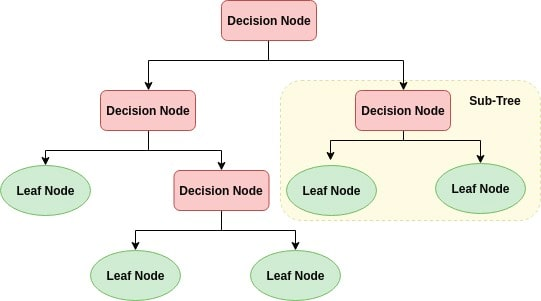

Figure above shows the idea behind a commonly used decision tree model.

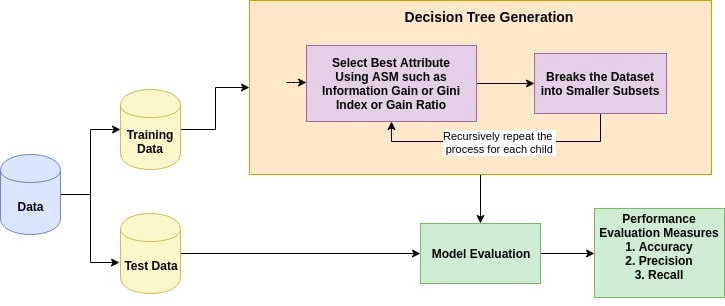

Fugure above shows the working of a decision tree 

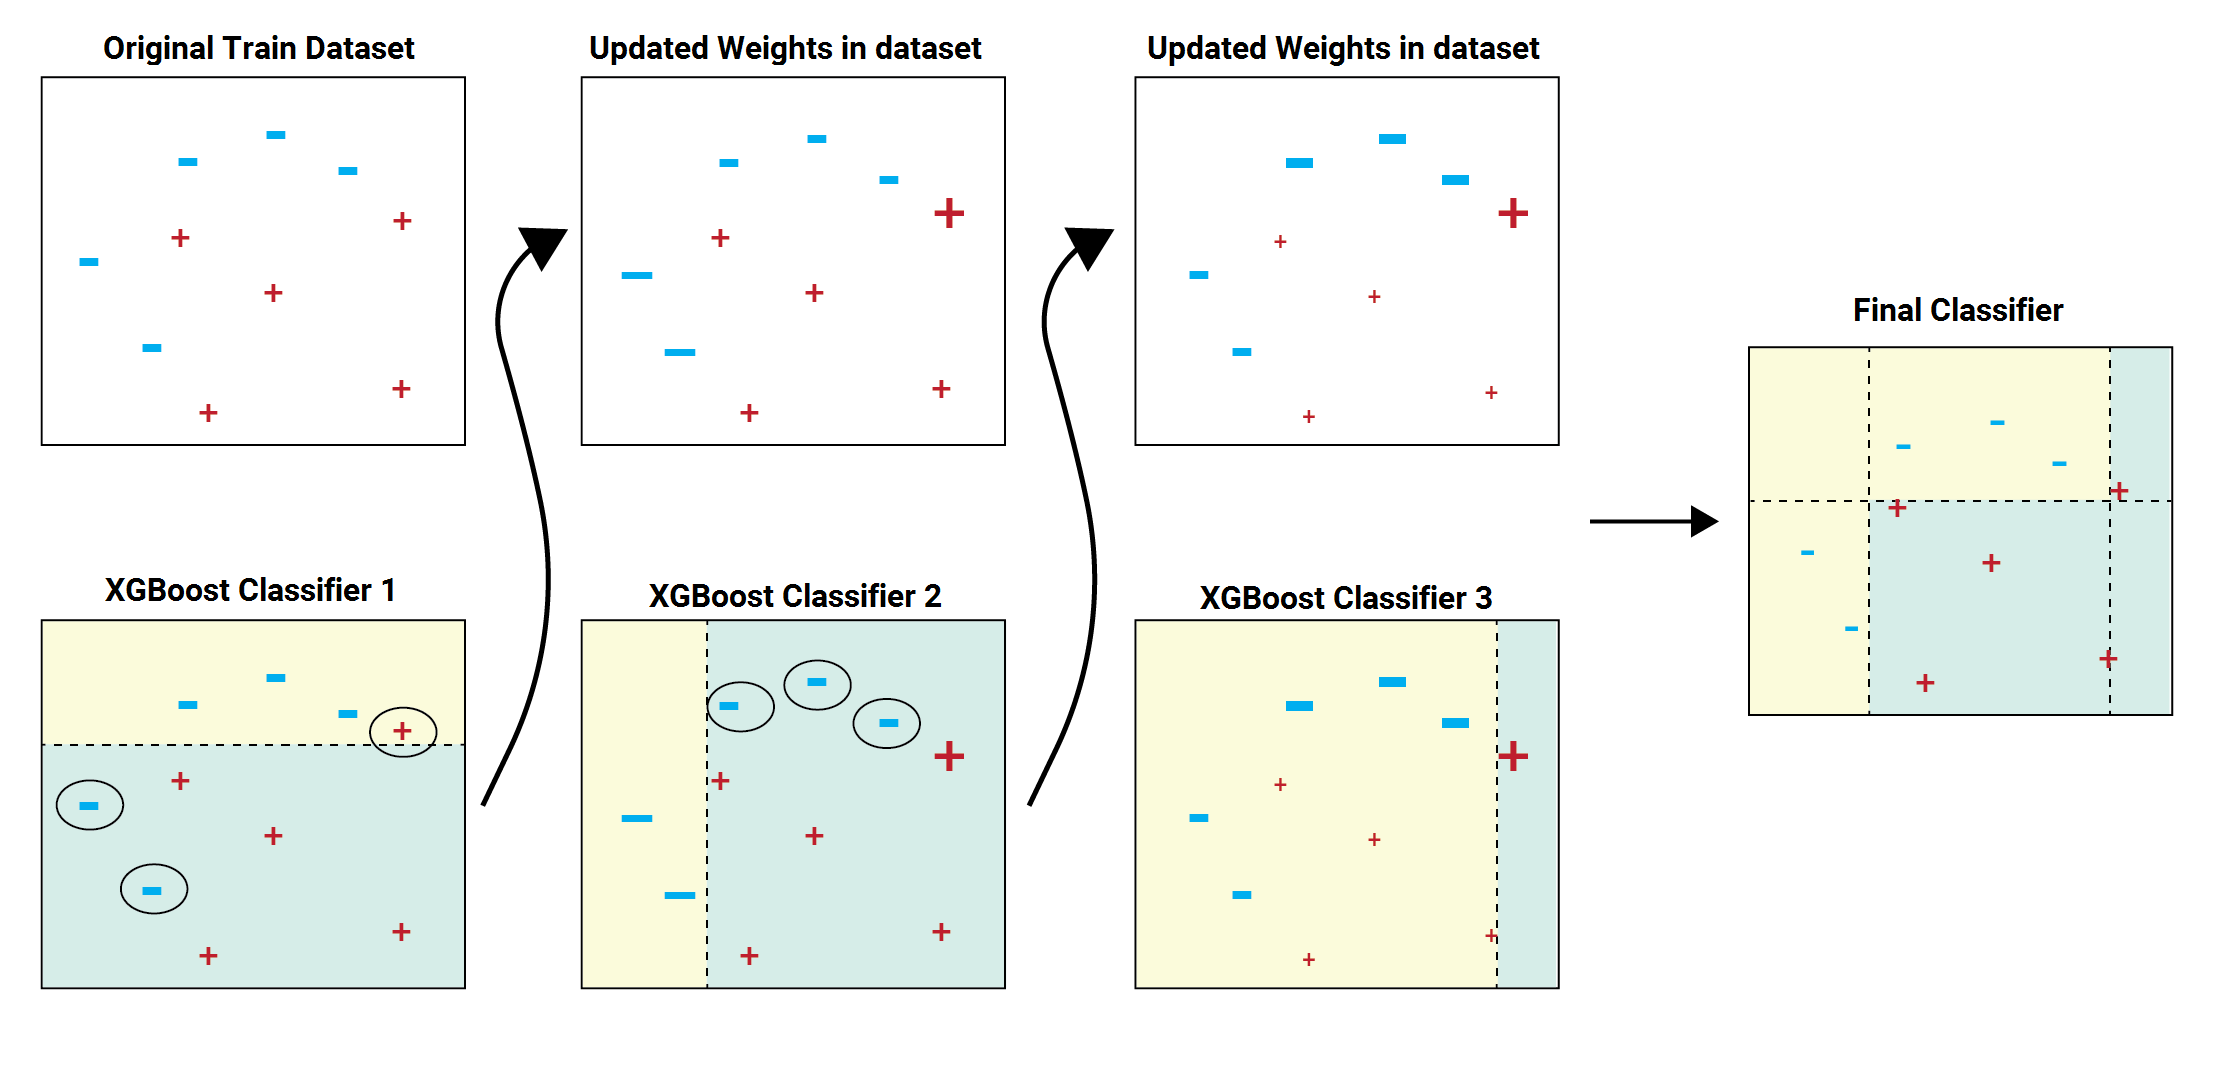

Figure above provides a overview of xgboost algorithm. XGBoost is a tree based ensemble machine learning algorithm that combines bagging and boosting, which is a scalable machine learning system. Explaining xgboost in detail is beyond the scope of this notebook.

In [254]:
# The following code imports XGboost classifier form xgboost library
from xgboost import XGBClassifier
# we assign the classifier to a variable model as shown below
model = XGBClassifier()
# We train our model on the training data after tfidf vectorization using the model.fit() function
model.fit(tfidf_train,y_train)

XGBClassifier()

Wow! Our model is now trained and ready to make predictions. Remember that we saved a subset of the Dataframe, the "Test Set"? Lets use that to try test our brand new model.

In [255]:
# In the following code we predict the results of X_test using model.predict() function, and assign the results to the variable y_pred.
y_pred = model.predict(tfidf_test)
# Lets take a look at how the predictions look like, we should get a array of "M" and "F".
y_pred

array(['M', 'M', 'M', ..., 'M', 'M', 'M'], dtype=object)

undersnding our results : 

The y_pred contains a array of predictions, each entry is a result for a input in the X_test's Dialogue column. The number of entries should be equal to the length of X_test 

In [256]:
# The following code compares the length of our predictions to the length of our test set with "==" operator, this should return true if both lengths are equal
len(x_test) == len(y_pred)

True

In [257]:
# The following code creates a dataframe with the data in x_test with pd.DataFrame() function
results = pd.DataFrame(x_test)
# The following code inserts a new column with name "Predictions". The values in this column represent our predictions
results['Predictions'] = y_pred
# Lets print out the results so we can compare the input and results side by side
results.head()

,Cleaned_Dialogue,Predictions
171949,know first name,M
26863,red sky night sailor delight,M
50534,put shit,M
4442,ah ha well make effort acquire could use good ...,M
213937,go forever know,M


# Try Yourself : Want to give your model a shot on your sentenses of your choosing? Lets try that

In [258]:
# In the following code we create a list of sentences to see what gender our model predicts for each sentense. 
# I have choosen first two sentences I think should a male would say, and second two sentenses for what a Female would say.
# Feel free to replace the sentenses with your own choices and see what kind of predictions our model makes.
dummy = ["I am a man", 'How are you girl?', "Oh god, this is so pretty!", 'thank you benjamin']
# We will have to vectorize the sentences with tfidf transformaton before we can predict results on it. 
dummy_tfidf = tfidf_vectorizer.transform(dummy)
# Moment of truth! lets see what predictions we make on each sentense, with model.predict() function
model.predict(dummy_tfidf)

array(['M', 'M', 'F', 'F'], dtype=object)

Thats pretty accurate! although we might not be so lucky all the time, Go ahead try different sentences seewhich ones our model gets right, and which one it fails 

# Evaluating the model

In [259]:
# The easiest way to check how good our model is going is by checking its accuracy, the following code finds the accuracy score using the model.score() function
acc = model.score(tfidf_test, y_test)
# Lets print the accuracy results
print("Accuracy of XGboost is  :", acc)

Accuracy of XGboost is  : 0.7071275806381214


Thats not too bad for first try, We can easily get better scores by tuning our model and trying out different algorithms

Lets see some advanced metrics for model evaluation.

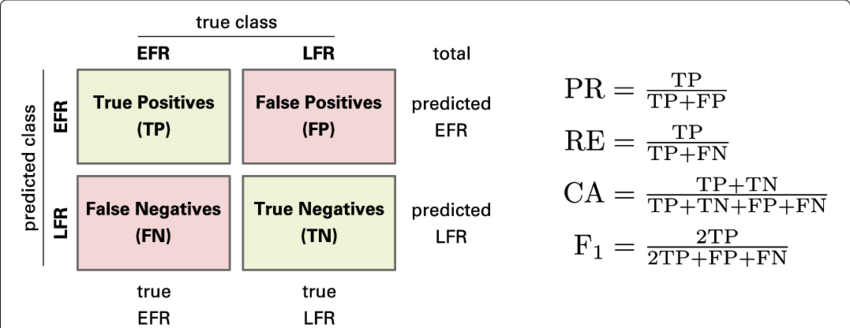

In order to understand some advance metrics lets look at some definations

Precision is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value.

A true positive is an outcome where the model correctly predicts the positive class. Similarly, a true negative is an outcome where the model correctly predicts the negative class.

A false positive is an outcome where the model incorrectly predicts the positive class. And a false negative is an outcome where the model incorrectly predicts the negative class.



Precision = True Positives / (True Positives + False Positives)

Recall is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. Recall is the same as sensitivity.

Recall = True Positives / (True Positives + False Negatives)

F-Measure or F1 score: that calculates the harmonic mean of the precision and recall (harmonic mean because the precision and recall are rates).
The F-Measure can be calculated by calling the f1_score() function that takes the true class values and the predicted class values as arguments.

F1 score =  (2 * Precision * Recall) / (Precision + Recall)

In [260]:
# A all in one tool to print out popular metrics is classification report
# This lets us see the precission, recall, F1 score, etc all in one table!
# following code loads classification report from sklearn.metrics
from sklearn.metrics import classification_report
# The following code prints various metrics in the clssification report.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           F       0.76      0.01      0.02      6747
           M       0.71      1.00      0.83     16164

    accuracy                           0.71     22911
   macro avg       0.73      0.50      0.42     22911
weighted avg       0.72      0.71      0.59     22911



# Conclusion 🙏
We can now identify the gender person by analyzing his/her sentences. How cool is that!

We can further improve the model score by various methods, but this notebook is intented towards providing a brief overview of the implementation.

This is not the only way to solve this problem, there are simpler and more advanced approaches depending on the situation, hope this notebook strikes a good balance.




# Thank you for Reading 